In [26]:
import numpy as np
import pandas as pd
from IPython.display import display
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
# import tkinter
import matplotlib
%matplotlib inline
# matplotlib.use('TkAgg')



In [27]:
# cc_bb_dir = '/mnt/d/physics/gamma-optical/2001/output/bayesian_block_cc/'
cc_bb_dir = './change_points/'
cc_dir = './dat/'
cc_sig_dir = './dat/'

# object_arr = np.arange(0,763)

In [28]:
object_arr = np.array([7020,7021,7022,7030,7031,7032])

df_arr = []
for oo in range(0,len(object_arr)):
    object_num = object_arr[oo]

    cc_bb_file = cc_bb_dir+'object'+str(object_num).zfill(4)+'_cc_change_points_000.dat'
    
    try:
        read_in_bb = np.loadtxt(cc_bb_file)
#         print('Working on object '+str(object_num))
#         print('bayesian block array shape: '+str(read_in_bb.shape))
    except:
        print("Couldn't read cc_bb file for object "+str(object_num))
        continue
        
    bb_time_index = read_in_bb[0].astype(int)
    bb_bin_norm = read_in_bb[1]
    num_bins = len(bb_time_index)


    bb_bin_start = bb_time_index

    bb_bin_end = np.zeros(len(bb_bin_start)).astype(np.int)
    bb_bin_end[:-1] = bb_time_index[1:]
    bb_bin_end[-1] = 14999

    # print(bb_bin_start)
    # print(bb_bin_end)


    cc_file = cc_dir+'object'+str(object_num).zfill(4)+'_stats000.dat'
    # read_in_cc = np.loadtxt(cc_file)
    # print(read_in_cc.shape)

    cc_sig_file = cc_sig_dir+'cross_object'+str(object_num).zfill(4)+'_all_stats_000.dat'
    # read_in_cc_sig = np.loadtxt(cc_sig_file)
    # print(read_in_cc_sig.shape)



    ## Reading in cross correlation values

    read_in = np.loadtxt(cc_file)

    time_err = read_in[0]
    data_err = read_in[1:]

    cor_mean = data_err[0]
    cor_err_d = cor_mean-data_err[1]
    cor_err_u = data_err[2]-cor_mean

    # expected_cor_up = cor_err_u *np.sqrt(2/np.pi)
    # expected_cor_dn = cor_err_d *np.sqrt(2/np.pi)

    # expected_cor = cor_mean + expected_cor_up - expected_cor_dn

    # cor_mean = expected_cor

    # print('cc array shape: '+str(data_err.shape))

    ## Making significance function

    read_in = np.loadtxt(cc_sig_file)
    time = read_in[0]
    data = read_in[1:] ## significance
    data = data[:-2] ## getting rid of "all"

    cc_significance = np.zeros(len(time))

    significance = np.array([0., -1., 1., -2., 2., -3., 3.])
    for ii in range(0,len(time)):
        significance_function = interp1d(data.T[ii], significance, axis=0, fill_value='extrapolate')
        cc_significance[ii] = significance_function(cor_mean[ii])

    cc_significance[np.isnan(cc_significance)] = 0.
    # print(cc_significance)

    ## Find max significance in bb bin

    avg_sig = np.zeros(num_bins)
    max_sig = np.zeros(num_bins)
    max_cc_index = np.zeros(num_bins).astype(np.int)

    for ii in range(0,num_bins):
        sig_arr = cc_significance[bb_bin_start[ii]:bb_bin_end[ii]+1]
        cc_arr = cor_mean[bb_bin_start[ii]:bb_bin_end[ii]+1]
        index_arr = np.arange(bb_bin_start[ii], bb_bin_end[ii]+1).astype(np.int)
        if np.average(sig_arr) >= 0:
            avg_sig[ii] = np.average(sig_arr)
            max_sig[ii] = np.amax(sig_arr)
            max_cc_index[ii] = index_arr[np.argmax(cc_arr)] 
        else:
            avg_sig[ii] = np.average(sig_arr)
            max_sig[ii] = np.amin(sig_arr)
            max_cc_index[ii] = index_arr[np.argmin(cc_arr)] 

    # print(avg_sig[:10])
    # print(max_sig[:10])
    # print(max_cc_index[:10])


    '''
    Arrays:
    time
    cor_mean
    bb_bin_start, bb_bin_end, bb_bin_norm
    max_sig, max_cc_index

    We want 
    bin_start_time, bin_end_time, max_cc_in_bin_time, max_cc_in_bin, max_sig_in_bin
    for only sig >= +(-) 2 for local max(min)
    '''

    output_arr = np.zeros([1,5])
    for ii in range(1,num_bins-1):
        if time[bb_bin_end[ii]] < -1500. or time[bb_bin_start[ii]] > 2500.:
            continue

        if bb_bin_norm[ii] >= 0:
            if bb_bin_norm[ii] > bb_bin_norm[ii+1] and bb_bin_norm[ii] > bb_bin_norm[ii-1]:
                bin_start_time = time[bb_bin_start[ii]]
                bin_end_time = time[bb_bin_end[ii]]
                max_cc_in_bin_time = time[max_cc_index[ii]]
                max_cc_in_bin = cor_mean[max_cc_index[ii]]
                max_sig_in_bin = max_sig[ii]
                avg_sig_in_bin = avg_sig[ii]

                if avg_sig_in_bin >= 3.:
                    new_row = np.array([bin_start_time, bin_end_time, max_cc_in_bin_time, max_cc_in_bin, max_sig_in_bin])
                    output_arr = np.append(output_arr, [new_row], axis=0)

        elif bb_bin_norm[ii] < 0:
            if bb_bin_norm[ii] < bb_bin_norm[ii+1] and bb_bin_norm[ii] < bb_bin_norm[ii-1]:
                bin_start_time = time[bb_bin_start[ii]]
                bin_end_time = time[bb_bin_end[ii]]
                max_cc_in_bin_time = time[max_cc_index[ii]]
                max_cc_in_bin = cor_mean[max_cc_index[ii]]
                max_sig_in_bin = max_sig[ii]
                avg_sig_in_bin = avg_sig[ii]

                if avg_sig_in_bin <= -3.:
                    new_row = np.array([bin_start_time, bin_end_time, max_cc_in_bin_time, max_cc_in_bin, max_sig_in_bin])
                    output_arr = np.append(output_arr, [new_row], axis=0)

    if len(output_arr) > 1:
        output_arr = output_arr[1:]
    else:
        continue

    num_sig_bins = len(output_arr)
    output_arr = np.append(object_num*np.ones([num_sig_bins,1]), output_arr, axis = 1)
    
    if len(df_arr) == 0:
        df_arr = output_arr.T
    else:
        df_arr = np.append(df_arr, output_arr.T, axis=1)
    # print(len(output_arr))
    # print(output_arr)


In [29]:
'''
Convert data to pandas data frame
'''
df_dict = {'object_num':df_arr[0].astype(np.int), 
           'max_cc_time':df_arr[3], 
           'time_start':df_arr[1], 
           'time_end':df_arr[2], 
           'max_cc_val':df_arr[4], 
           'max_sig':df_arr[5]}

df = pd.DataFrame(df_dict)
# df = df.sort_values(by=['object_num', 'max_cc_val'], ascending=[True,False])


df['time_diff'] = df['time_end'] - df['time_start']
df = df.round({'time_start':1, 'time_end':1, 'max_cc_time':1, 'max_cc_val':5, 'max_sig':5, 'time_diff':1})

# print(df.to_markdown)
display(df)

outfilename = 'cc_sig_data.csv'
df.to_csv(outfilename, index=None)

,object_num,max_cc_time,time_start,time_end,max_cc_val,max_sig,time_diff
0,7020,-2.0,-5.2,4.4,0.21003,13.32646,9.6
1,7021,-0.8,-5.2,7.2,0.22433,14.17058,12.4
2,7022,-0.4,-8.0,22.4,0.05949,3.85407,30.4
3,7030,-580.8,-627.6,-542.8,-0.04829,-3.49788,84.8
4,7030,-0.8,-5.2,4.8,0.22100,16.50959,10.0
5,7031,-493.6,-515.6,-488.0,-0.04338,-3.16267,27.6
6,7031,0.0,-4.8,5.6,0.22683,16.98400,10.4
7,7032,10.8,-2.0,24.4,0.23200,17.49431,26.4
8,7032,1374.0,1248.8,1392.4,-0.05453,-4.10911,143.6


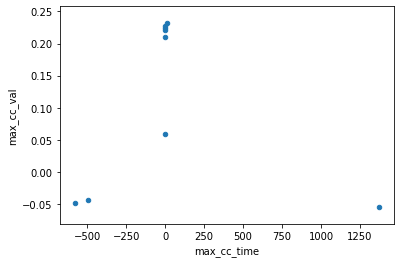

In [30]:
df.plot('max_cc_time', 'max_cc_val', kind='scatter')